In [45]:
from langgraph.graph import StateGraph,START, END
from typing import TypedDict,List ,Annotated,Literal
from pydantic import Field,BaseModel
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
import operator


In [46]:
load_dotenv()

True

In [47]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.7)

In [48]:
class SentinementSchema(BaseModel):
    sentiment:Literal['positive','negative']
    

In [49]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [50]:
stmodel=model.with_structured_output(SentinementSchema)

In [51]:
stmodel2=model.with_structured_output(DiagnosisSchema)

In [ ]:
prompt=f"this very bad moobile"
response=stmodel.invoke(prompt)
print(response.sentiment)   

ChatGoogleGenerativeAIError: Error calling model 'gemini-2.5-flash' (RESOURCE_EXHAUSTED): 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash\nPlease retry in 14.087626236s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash'}, 'quotaValue': '20'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '14s'}]}}

In [ ]:
class ReviewState(TypedDict):
    review:str
    sentiment:Literal['positive','negative']
    response:str
    diagnosis:dict

In [ ]:
def find_sentiment(state:ReviewState):
    prompt = f"for the following reviwe find the sentiment of the reviwe\n {state['review']}"
    sentiment=stmodel.invoke(prompt)
    
    return {'sentiment':sentiment}


def check_sentiment(state:ReviewState)-> Literal['positive_response','run_diagnosis']:
    sentiment=state['sentiment']
    if sentiment=='positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    
    

In [ ]:
def positive_response(state:ReviewState):
    prompt=f"""write a warm thank you message in response to this review:
    \n\n\"{state['review']}\"\n
    also ask user to kindly toleave the feedback on our website"""
    
    response=model.invoke(prompt).content
    
    return {'response':response}



def run_diagnosis(state:ReviewState):
    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
    """
    response=stmodel2.invoke(prompt)
    
    return {'diagnosis': response.model_dump()}


def negative_response(state:ReviewState):
    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
    The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
    Write an empathetic, helpful resolution message.
    """
    response=model.invoke(prompt).content
    
    return {'response':response}

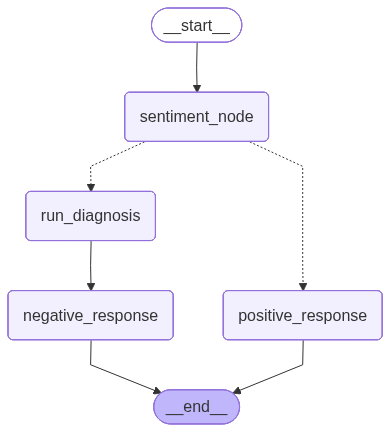

In [ ]:
graph=StateGraph(ReviewState)

graph.add_node("sentiment_node",find_sentiment)
graph.add_node("positive_response",positive_response)
graph.add_node("negative_response",negative_response)
graph.add_node("run_diagnosis",run_diagnosis)

graph.add_edge(START,'sentiment_node')
graph.add_conditional_edges('sentiment_node',check_sentiment)
graph.add_edge('positive_response', END)

graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)



workflow=graph.compile()

workflow

In [ ]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

KeyError: 'issue_type'